# Segmentation

This notebook will cover end-to-end segmentation in the `DataBlock` API as well as training

First let's install our libraries

In [0]:
#import os
#!pip install -q torch torchvision feather-format kornia pyarrow Pillow wandb nbdev fastprogress --upgrade 
#!pip install -q git+https://github.com/fastai/fastcore  --upgrade
#!pip install -q git+https://github.com/fastai/fastai2 --upgrade
#os._exit(00)

Now let's grab the imports we will need for this

In [0]:
from fastai2.basics import *
from fastai2.vision.all import *
from fastai2.callback.all import *

And let's grab our data

In [0]:
path = untar_data(URLs.CAMVID)

Now let's try making our `DataBlock`. Our validation set is in a text document, `valid.txt`

In [0]:
valid_fnames = (path/'valid.txt').read().split('\n')

In [0]:
valid_fnames[:5]

['0016E5_07959.png',
 '0016E5_07961.png',
 '0016E5_07963.png',
 '0016E5_07965.png',
 '0016E5_07967.png']

Now we need a split function that will split our data from a list of items to use as our validation set. Let's make a `ListSplitter` function to do so. We will use a private `inner` function to grab everything

In [0]:
def ListSplitter(valid_items):
  def _inner(items):
    val_mask = tensor([o.name in valid_items for o in items])
    return [~val_mask, val_mask]
  return _inner

The above function will grab our validation masks that are in our filenames *if* they fall into our `valid_items` array. If not, they will go into our training set

Now let's create a `DataBlock`. Our `x`'s are `ImageBlock`'s, and our `y`'s are `ImageBlock`'s with contain a `PILMask`. Our splitter will be our custom split function, and our `get_y` needs to grab from the stem and suffix

We'll use a `get_msk` function to grab the corresponding mask we want. For this dataset, they are stored away in `labels` with a filename of `mask1_P.jpg` (for example), where we have an added `_P`

In [0]:
get_msk = lambda o: path/'labels'/f'{o.stem}_P{o.suffix}'

One other note, is we have a vocabulary we want to use, let's grab that real quick. These codes correspond to our vocabular of what each class represents. We will need this for our metric

In [0]:
codes = np.loadtxt(path/'codes.txt', dtype=str)

In [0]:
codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car',
       'CartLuggagePram', 'Child', 'Column_Pole', 'Fence', 'LaneMkgsDriv',
       'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving',
       'ParkingBlock', 'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk',
       'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel',
       'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

Now let's make our `DataBlock`

In [0]:
camvid = DataBlock(blocks=(ImageBlock, ImageBlock(cls=PILMask)),
                   get_items=get_image_files,
                   splitter=ListSplitter(valid_fnames),
                   get_y=get_msk)

In [0]:
dbunch = camvid.databunch(path/'images', bs=8,
                          batch_tfms=[*aug_transforms(size=(360,480)), Normalize(*imagenet_stats)])

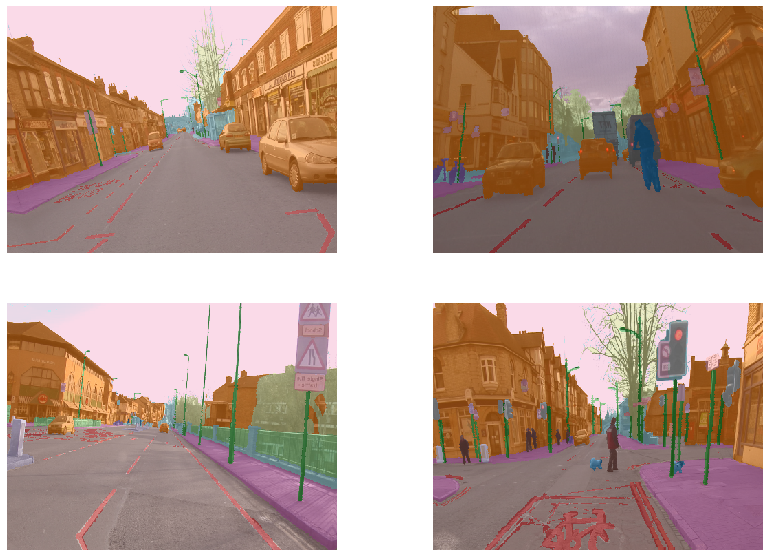

In [0]:
dbunch.show_batch(max_n=4, vmin=1, vmax=30, figsize=(14, 10))

Perfect! Let's now make our `dbunch`'s vocabular to those `codes` we defined earlier

In [0]:
dbunch.vocab = codes

We need a few more pieces and then we're good to train. We want a specific accuracy function to use when training. For this, we'll first have a way to decode our pixels to names with a `name2id` function. Then we will make an accuracy function, `acc_camvid` that takes into account a `void` category in our image (we want to completely ignore them)

In [0]:
name2id = {v:k for k,v in enumerate(codes)}

In [0]:
name2id

{'Animal': 0,
 'Archway': 1,
 'Bicyclist': 2,
 'Bridge': 3,
 'Building': 4,
 'Car': 5,
 'CartLuggagePram': 6,
 'Child': 7,
 'Column_Pole': 8,
 'Fence': 9,
 'LaneMkgsDriv': 10,
 'LaneMkgsNonDriv': 11,
 'Misc_Text': 12,
 'MotorcycleScooter': 13,
 'OtherMoving': 14,
 'ParkingBlock': 15,
 'Pedestrian': 16,
 'Road': 17,
 'RoadShoulder': 18,
 'SUVPickupTruck': 22,
 'Sidewalk': 19,
 'SignSymbol': 20,
 'Sky': 21,
 'TrafficCone': 23,
 'TrafficLight': 24,
 'Train': 25,
 'Tree': 26,
 'Truck_Bus': 27,
 'Tunnel': 28,
 'VegetationMisc': 29,
 'Void': 30,
 'Wall': 31}

Now let's write that accuracy function!

In [0]:
void_code = name2id['Void']

In [0]:
def acc_camvid(inp, targ):
  targ = targ.squeeze(1)
  mask = targ != void_code
  return (inp.argmax(dim=1)[mask]==targ[mask]).float().mean()

Now that we are there, we just a few more pieces. Our loss function is still `CrossEntropyFlat`, however since we are getting a list of masks, we want to use an axis of 1. We also can pass in a `config` for our `unet`

In [0]:
opt_func = partial(Adam, lr=3e-2, wd=0.01)

In [0]:
loss_func = CrossEntropyLossFlat(axis=1)

In our configuration, we can specify if we want to use `Simple Self Attention` and a `Mish` activation easily too. Let's do that

In [0]:
config = unet_config(norm_type=None, self_attention=True, act_cls=MishJit)

Now let's make our `Learner`!

In [0]:
learn = unet_learner(dbunch, resnet34, loss_func=loss_func, opt_func=opt_func,
                     path=path, metrics=acc_camvid, config=config, wd_bn_bias=True)

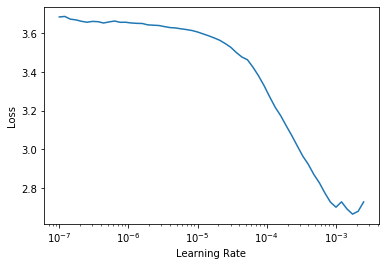

In [0]:
learn.lr_find()

We'll use a learning rate of somewhere around 4e-3

In [0]:
lr = 4e-3
learn.freeze()

Let's fit!

In [0]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9, wd=1e-2)

epoch,train_loss,valid_loss,acc_camvid,time
0,1.086387,0.678972,0.840834,04:05
1,0.733231,0.534902,0.850553,03:56
2,0.615357,0.521136,0.849283,03:56
3,1.318228,0.906255,0.770352,03:55
4,0.860576,0.582869,0.838136,03:56
5,0.638527,0.460563,0.874020,03:56
6,0.591133,0.553431,0.859919,03:56
7,0.561734,0.454768,0.880706,03:56
8,0.508886,0.448392,0.878612,03:56
9,0.450633,0.344832,0.905409,03:56


Now we can save our model, and unfreeze (if we run out of memory we can also reload it back in)

In [0]:
learn.save('stage-1')

In [0]:
learn.load('stage-1')
learn.unfreeze()

Now let's adjust our learning rate for this unfreezing

In [0]:
lrs = slice(lr/400,lr/4)

In [0]:
learn.fit_one_cycle(12, lrs, pct_start=0.8, wd=1e-2)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.390662,0.330084,0.907517,03:55
1,0.372530,0.318737,0.911392,03:56
2,0.362637,0.326293,0.906382,03:55
3,0.353055,0.303596,0.917386,03:56
4,0.343731,0.306116,0.914750,03:56
5,0.339166,0.297592,0.917859,03:56
6,0.330065,0.305890,0.916106,03:56
7,0.330131,0.329964,0.905542,03:56
8,0.318602,0.317580,0.912660,03:56
9,0.305700,0.292495,0.916993,03:56


And we are done!